Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)

![](descargar.png)

In [1]:
airbnb <-read.csv('airbnb-listings.csv',
                  sep = ';')
options(repr.plot.height=4,
        repr.plot.width=6,
        repr.plot.res = 300)

In [64]:
library(dplyr)
install.packages("caret")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [3]:
airbnb <- airbnb[c('City',
                   'Room.Type',
                   'Neighbourhood',
                   'Accommodates',
                   'Bathrooms',
                   'Bedrooms',
                   'Beds',
                   'Price',
                   'Square.Feet',
                   'Guests.Included',
                   'Extra.People',
                   'Review.Scores.Rating',
                   'Latitude', 
                   'Longitude')]

Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [4]:
library(dplyr)
df_madrid <- airbnb |>
        filter(City=='Madrid',
        Room.Type=='Entire home/apt',
        Neighbourhood != '') |>
        select(-Room.Type,-City) #No son necesarias: "Room.Type",'City'

Crea una nueva columna llamada Square.Meters a partir de Square.Feet. Recuerda que un pie cuadrado son 0.092903 metros cuadrados.

In [5]:
x = 0.092903
df_madrid$Square.Meters <- df_madrid$Square.Feet * x

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [6]:
x <- sum(is.na(df_madrid$Square.Meters))
y <- length(df_madrid$Square.Meters)
na_porcenje <- (x/y)*100

paste("porcentaje de los apartamentos no muestran los metros cuadrados:")
paste(round(na_porcenje,2),"%")

[1] "porcentaje de los apartamentos no muestran los metros cuadrados:"

[1] "93.8 %"

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [7]:
x <- length(which(df_madrid$Square.Meters == 0))
y <- sum(!is.na(df_madrid$Square.Meters))
zero_count <- (x/y)*100
paste("porcentaje de los apartamentos tienen 0 metros cuadrados:")
paste(round(zero_count,2),"%")

[1] "porcentaje de los apartamentos tienen 0 metros cuadrados:"

[1] "36.89 %"

Reemplazar todos los 0m^2 por NA 

In [9]:
df_madrid$Square.Meters[df_madrid$Square.Meters == 0] <- NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA. Pero **antes de crear el modelo** vamos a hacer:
* pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.
* crearemos una variable sintética nueva basada en la similitud entre barrios que usaremos en nuestro modelo.

Pinta el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 5382 rows containing non-finite values (`stat_bin()`).”


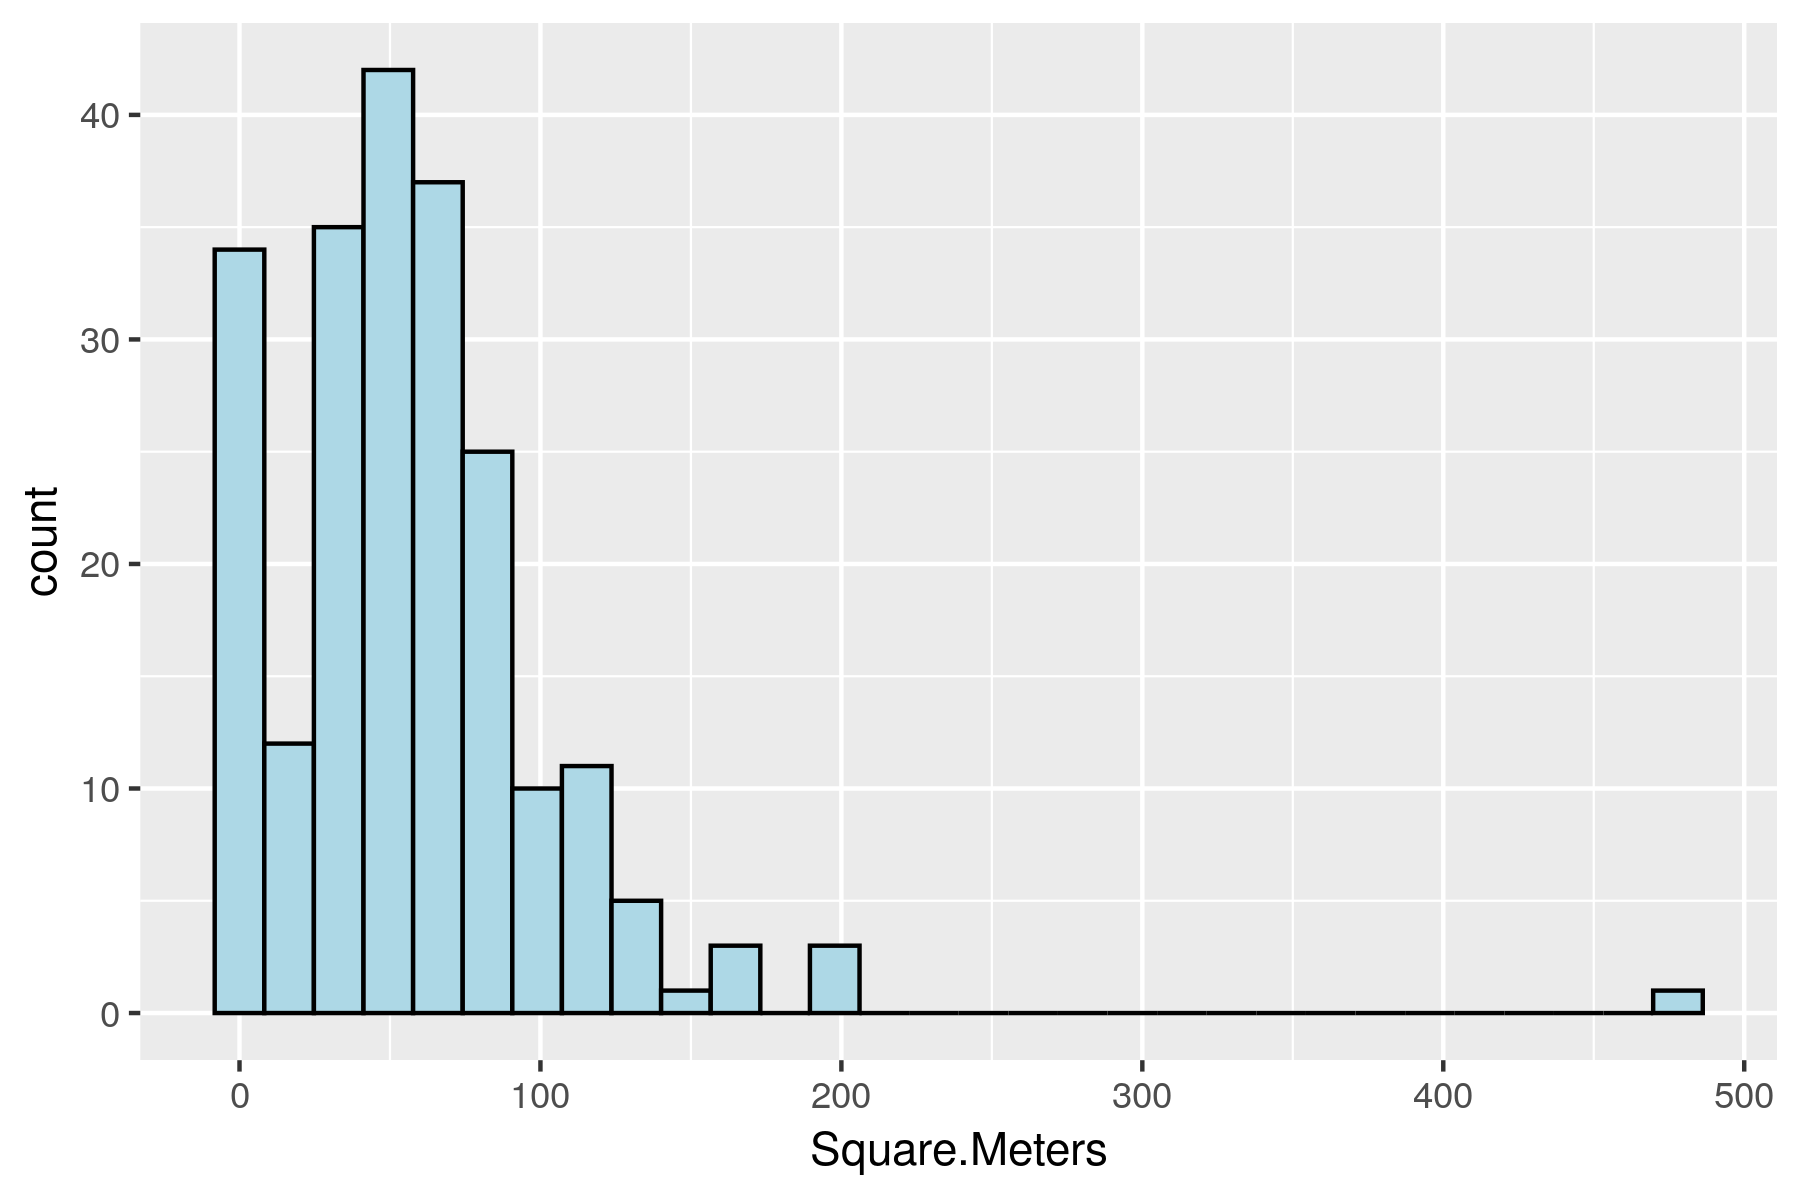

In [10]:
library(ggplot2)
options(repr.plot.height=4,repr.plot.width=6)

ggplot(data =df_madrid, aes(x=Square.Meters))+
geom_histogram(fill='lightblue', color='black')

Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [11]:
df_madrid$Square.Meters[df_madrid$Square.Meters < 20] <- NA
library(ggplot2)
options(repr.plot.height=4,repr.plot.width=6)


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 5427 rows containing non-finite values (`stat_bin()`).”


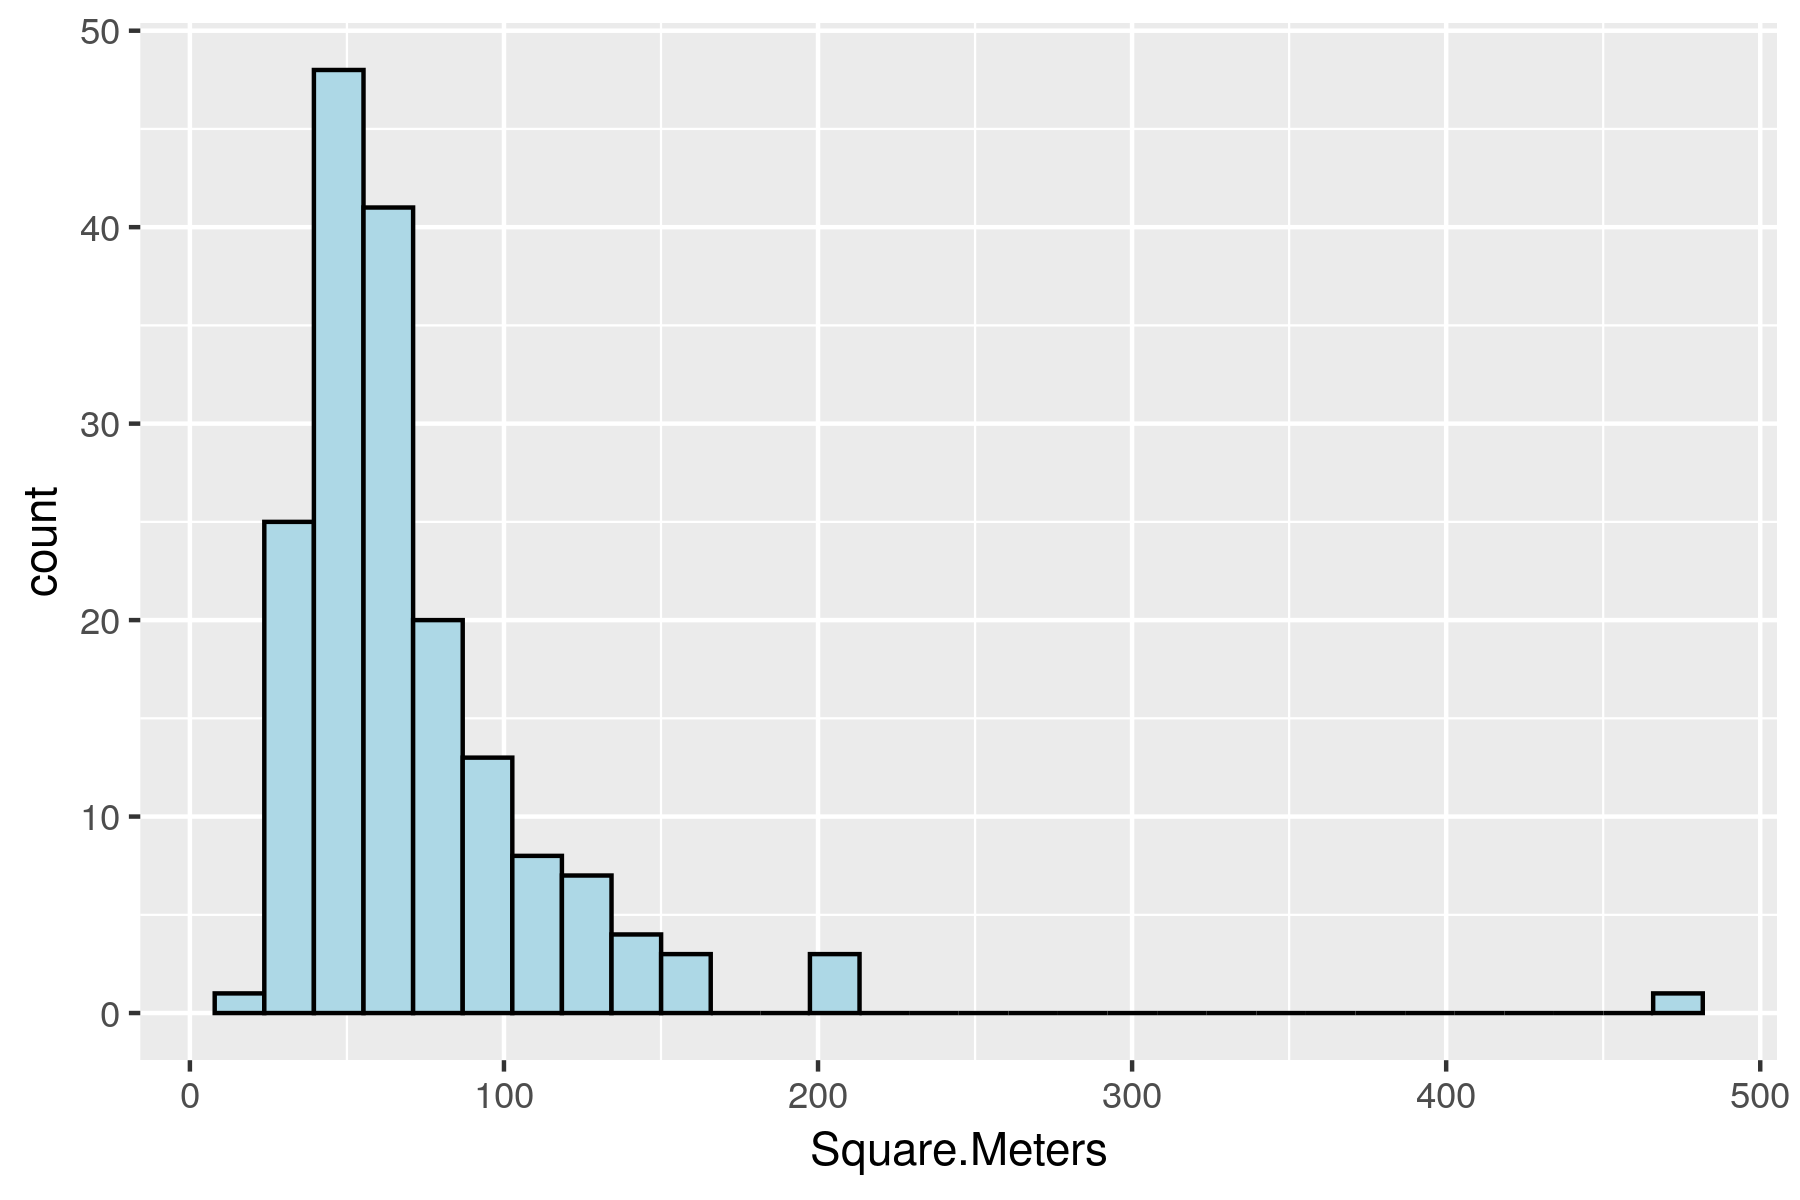

In [12]:
ggplot(data =df_madrid, aes(x=Square.Meters))+
geom_histogram(fill='lightblue', color='black')

Existen varios Barrios que todas sus entradas de Square.Meters son NA, vamos a eliminar del dataset todos los pisos que pertenecen a estos barrios.

In [13]:
df_group_barrios <- df_madrid |> group_by(Neighbourhood) |>
    summarise("Pisos" = sum(!is.na(Square.Meters)))

barrios <- df_group_barrios[df_group_barrios$"Pisos" > 0,
                            "Neighbourhood"] 

df_barrios <- pull(barrios,Neighbourhood)

df_madrid <- df_madrid[df_madrid$Neighbourhood %in% df_barrios,]

El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

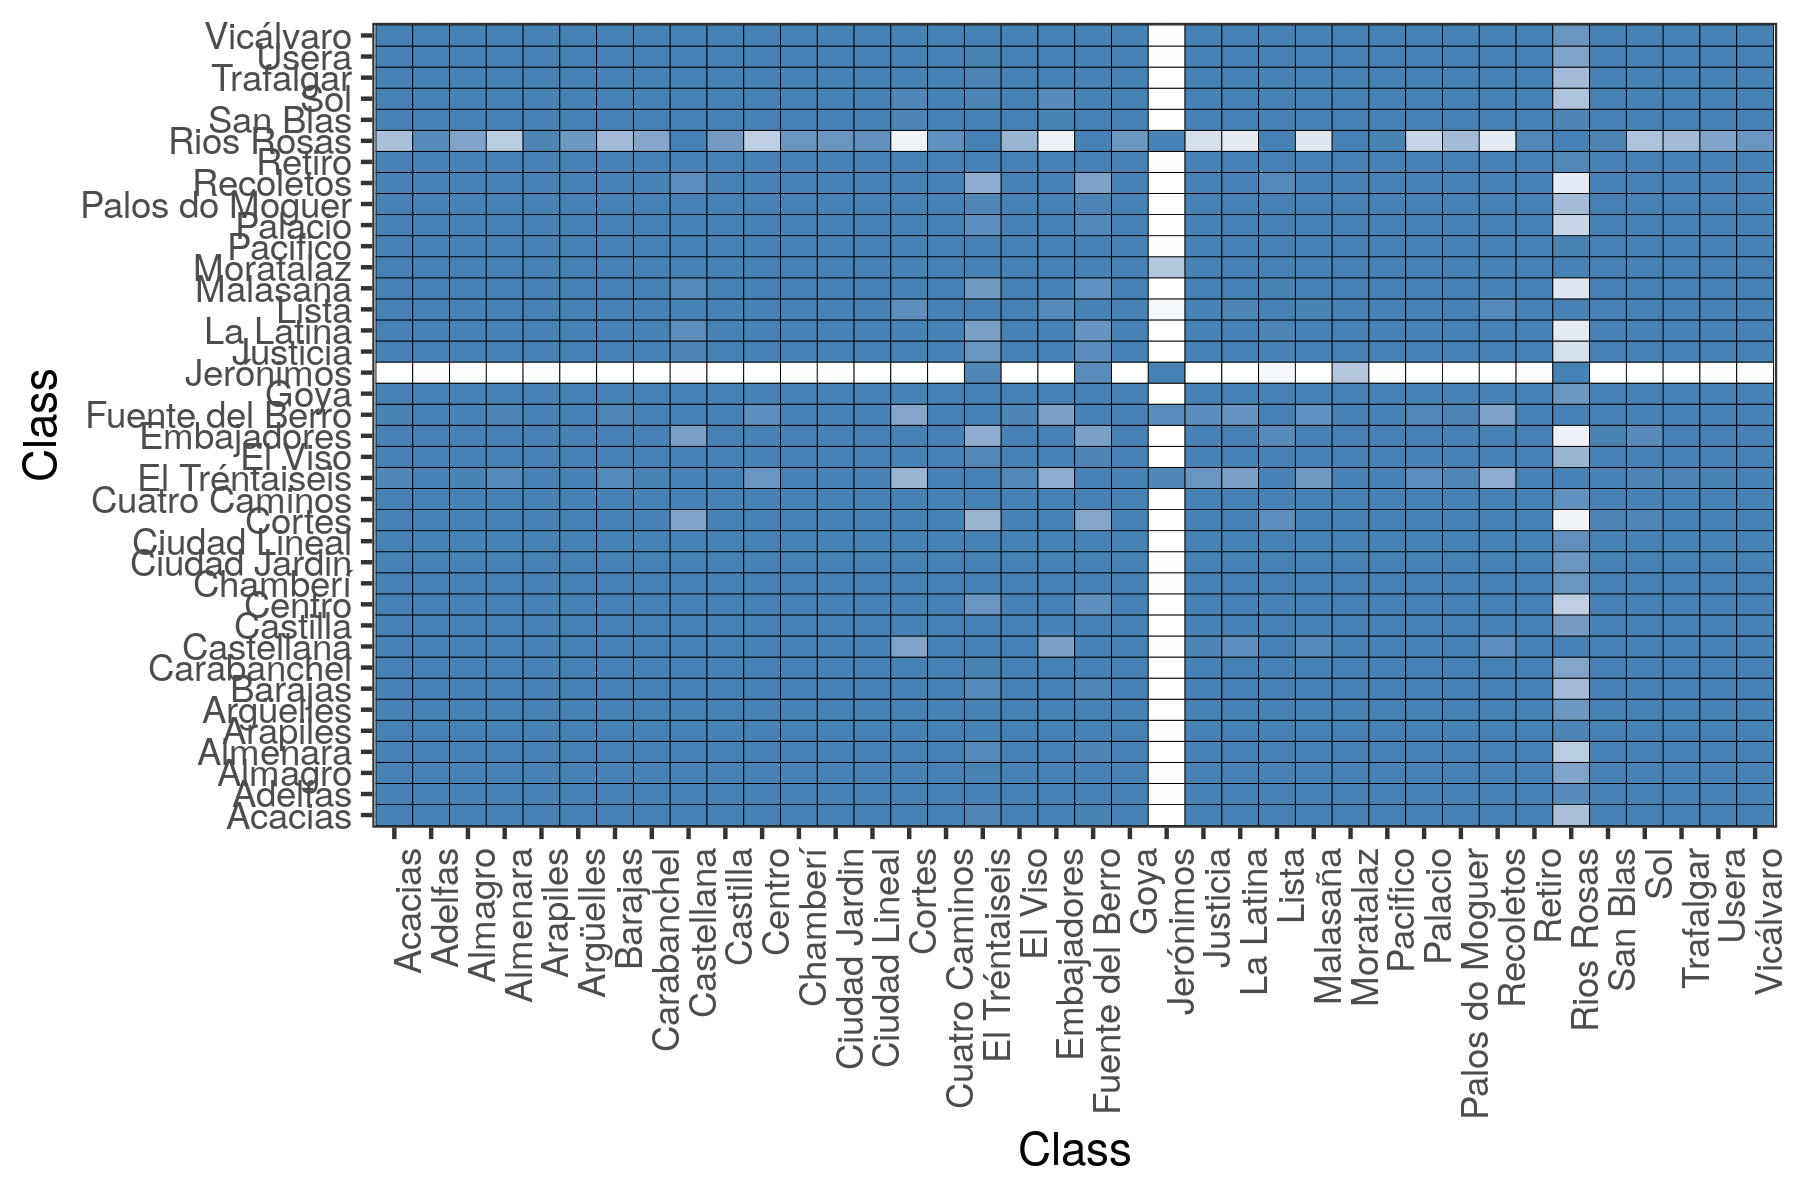

In [14]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


In [15]:
distancia <- 1 - resm

In [16]:
library(dendextend)
library(cluster)
library(stats)


---------------------
Welcome to dendextend version 1.16.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:stats’:

    cutree




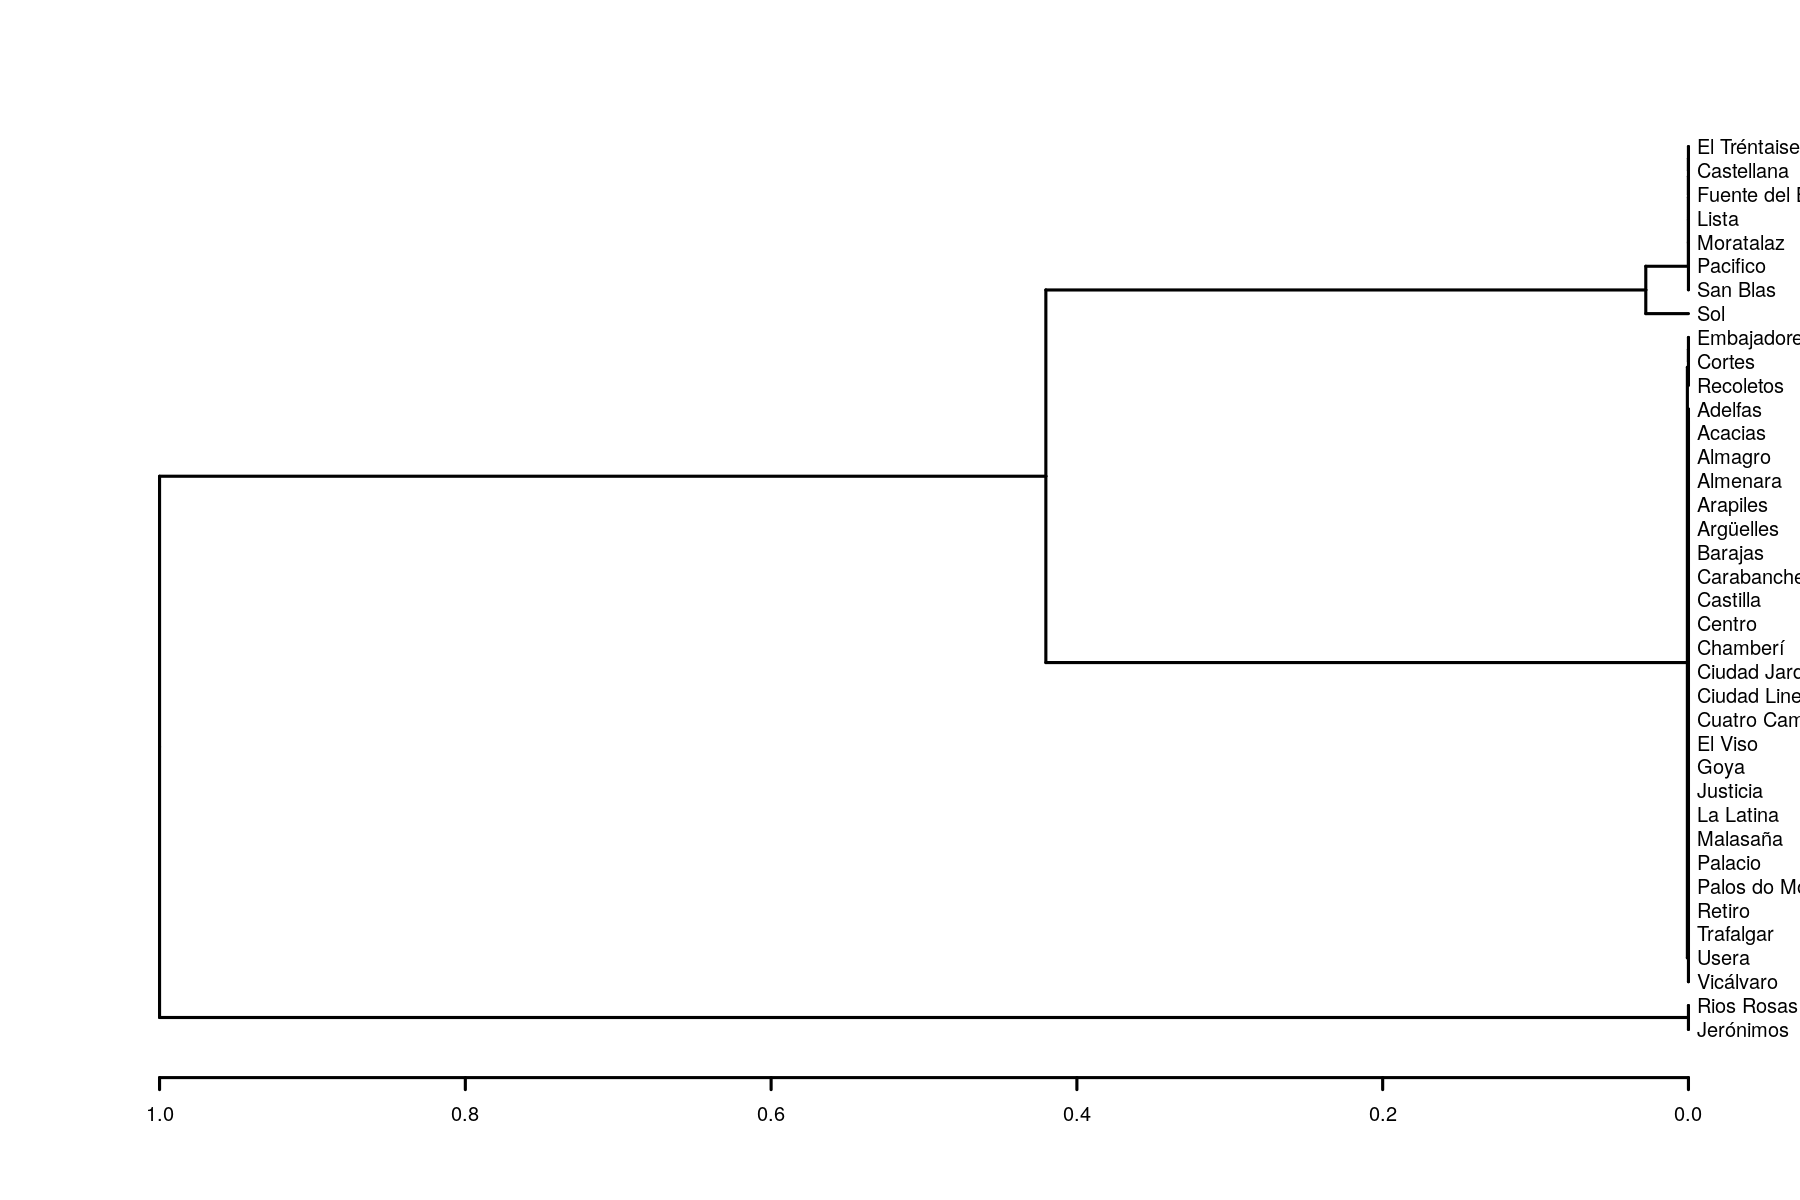

In [17]:
distancia <- as.dist(1 - resm)
#distancia a matriz de distancia

# Calcular jerarquía de clustering
cluster <- hclust(distancia, method="complete")

# Dibujar dendrograma
dendrograma <- as.dendrogram(cluster)
par(cex=0.4)
plot(dendrograma,horiz=TRUE)


¿Que punto de corte sería el aconsejable?, ¿cuantos clusters aparecen?

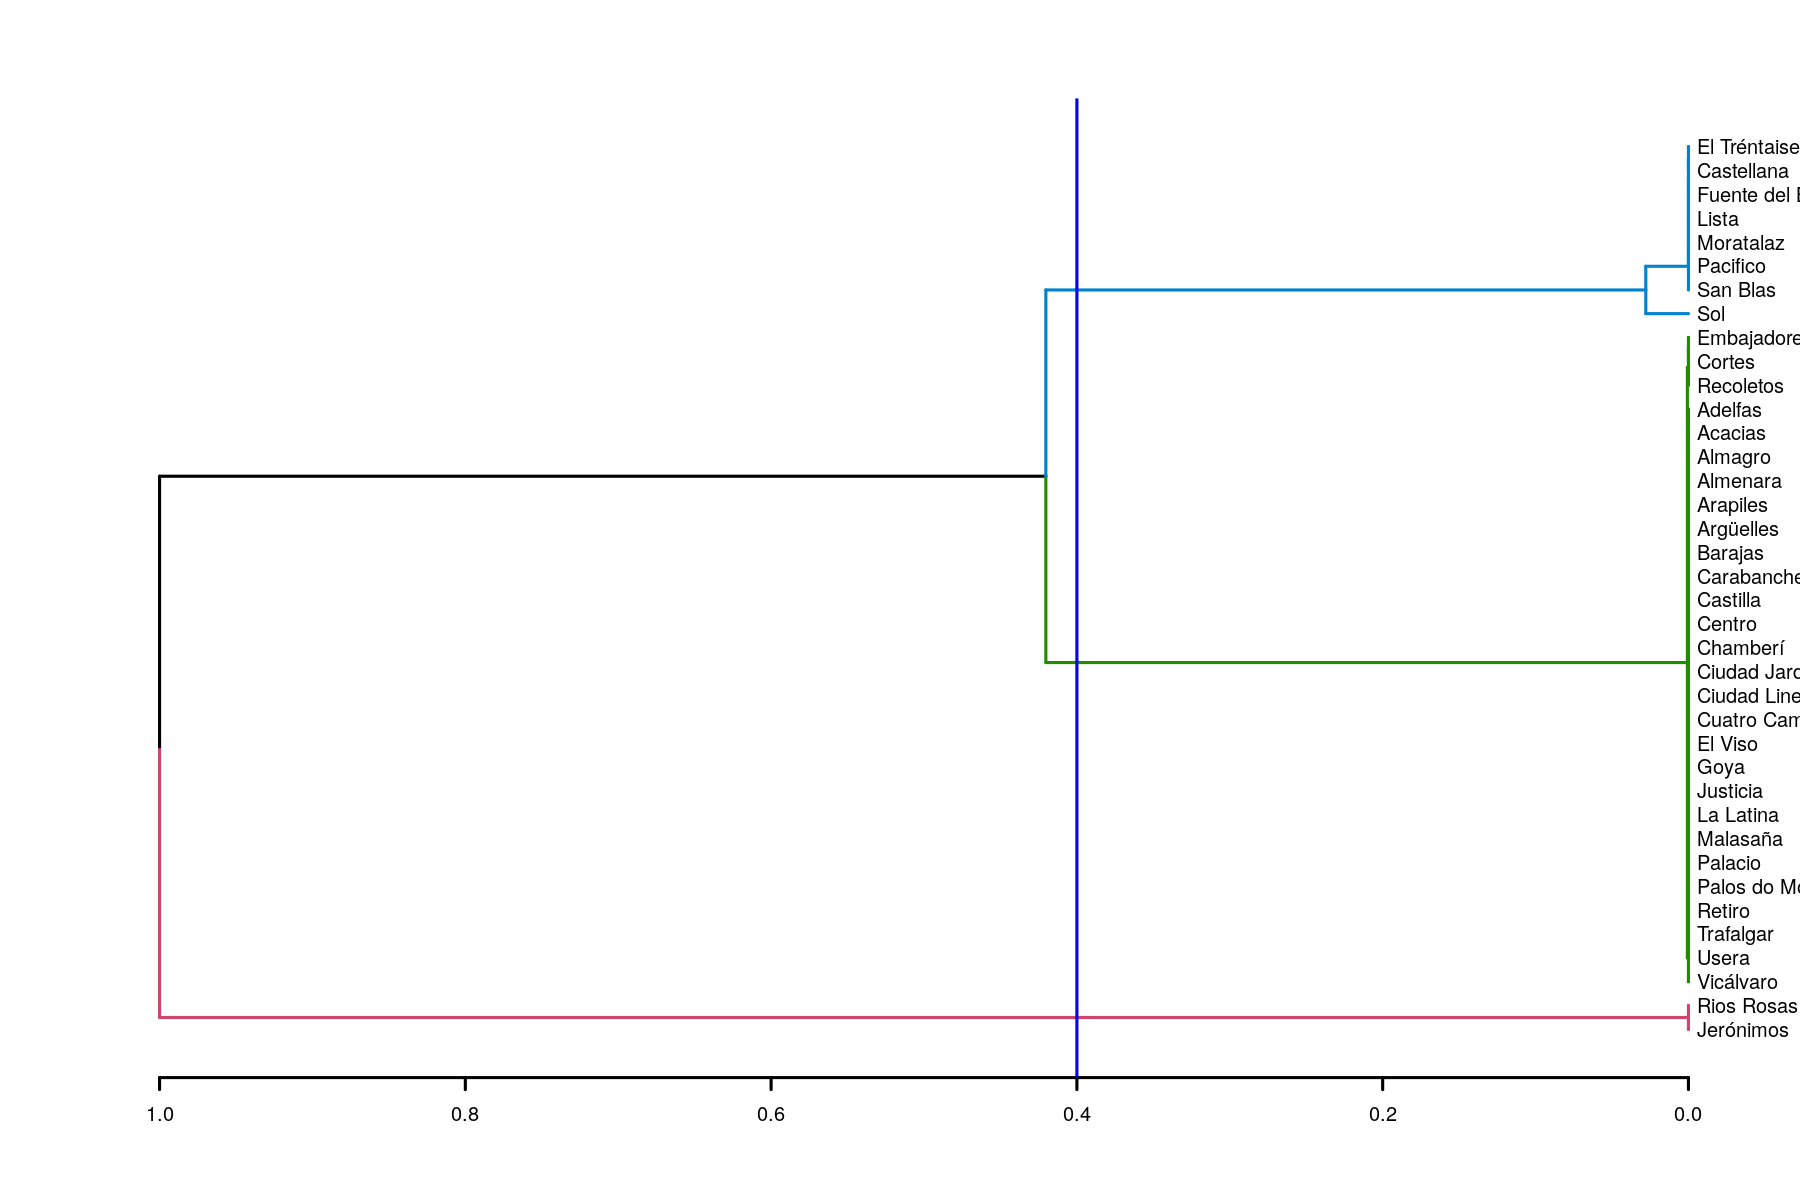

In [97]:
corte = 0.4
par(cex=0.4)
plot(color_branches(dendrograma,
                    h=corte),
                    horiz=TRUE)
abline(v=corte,
       col="blue")
c1 <- cutree_1h.dendrogram(dendrograma,h=corte) 

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [117]:
cl <- as.data.frame(cl ,
                    stringsAsFactors= TRUE)
colnames(cl)<-'Neighb_id'
df_madrid <- merge(df_madrid,cl,
                   by.x='Neighbourhood',
                   by.y=0)

df_madrid$Neighb_id <- as.factor(df_madrid$Neighb_id)

Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

In [118]:
library(dplyr)
df_madrid |> drop_na(Square.Meters) -> lm_madrid

ERROR: Error in drop_na(df_madrid, Square.Meters): could not find function "drop_na"


In [119]:
madrid_NA <- df_madrid |> filter(!is.na(Square.Meters))

set.seed(20)
idx <-sample(1:nrow(madrid_NA),nrow(madrid_NA)*0.7)

train=madrid_NA[idx,]
test=madrid_NA[-idx,]

summary(train)
summary(test)

 Neighbourhood       Accommodates      Bathrooms        Bedrooms    
 Length:121         Min.   : 2.000   Min.   :1.000   Min.   :0.000  
 Class :character   1st Qu.: 3.000   1st Qu.:1.000   1st Qu.:1.000  
 Mode  :character   Median : 4.000   Median :1.000   Median :1.000  
                    Mean   : 4.273   Mean   :1.279   Mean   :1.558  
                    3rd Qu.: 6.000   3rd Qu.:1.125   3rd Qu.:2.000  
                    Max.   :10.000   Max.   :4.000   Max.   :4.000  
                                     NA's   :1       NA's   :1      
      Beds           Price         Square.Feet   Guests.Included
 Min.   :1.000   Min.   : 32.00   Min.   : 237   Min.   :1.000  
 1st Qu.:1.000   1st Qu.: 59.75   1st Qu.: 484   1st Qu.:1.000  
 Median :2.000   Median : 74.50   Median : 646   Median :2.000  
 Mean   :2.579   Mean   : 98.22   Mean   : 733   Mean   :2.074  
 3rd Qu.:3.000   3rd Qu.:100.00   3rd Qu.: 861   3rd Qu.:2.000  
 Max.   :8.000   Max.   :500.00   Max.   :2153   Max.   :8

 Neighbourhood       Accommodates      Bathrooms        Bedrooms    
 Length:53          Min.   : 2.000   Min.   :1.000   Min.   :0.000  
 Class :character   1st Qu.: 4.000   1st Qu.:1.000   1st Qu.:1.000  
 Mode  :character   Median : 4.000   Median :1.000   Median :2.000  
                    Mean   : 5.075   Mean   :1.385   Mean   :1.755  
                    3rd Qu.: 6.000   3rd Qu.:1.625   3rd Qu.:2.000  
                    Max.   :16.000   Max.   :5.000   Max.   :5.000  
                                     NA's   :1                      
      Beds            Price         Square.Feet     Guests.Included
 Min.   : 1.000   Min.   : 20.00   Min.   : 291.0   Min.   :1.000  
 1st Qu.: 1.000   1st Qu.: 59.00   1st Qu.: 484.0   1st Qu.:1.000  
 Median : 2.000   Median : 77.00   Median : 646.0   Median :2.000  
 Mean   : 2.981   Mean   : 91.66   Mean   : 832.2   Mean   :2.189  
 3rd Qu.: 4.000   3rd Qu.:100.00   3rd Qu.: 883.0   3rd Qu.:2.000  
 Max.   :13.000   Max.   :365.00   Max. 

In [120]:
model <-lm(Square.Meters~Accommodates+Bathrooms+Bedrooms+
                 Beds+Price+Guests.Included+Extra.People+
                 Review.Scores.Rating+Neighb_id,
                 data=train)
summary(model)


Call:
lm(formula = Square.Meters ~ Accommodates + Bathrooms + Bedrooms + 
    Beds + Price + Guests.Included + Extra.People + Review.Scores.Rating + 
    Neighb_id, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-48.834 -12.412  -0.592   9.654  64.892 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            7.69102   28.00391   0.275 0.784137    
Accommodates           2.92118    2.33767   1.250 0.214245    
Bathrooms             18.61262    5.39075   3.453 0.000804 ***
Bedrooms              18.83548    3.46799   5.431  3.7e-07 ***
Beds                  -3.76822    2.18778  -1.722 0.087971 .  
Price                  0.07224    0.02800   2.580 0.011275 *  
Guests.Included       -3.19468    1.97497  -1.618 0.108782    
Extra.People           0.30193    0.21682   1.393 0.166736    
Review.Scores.Rating   0.14798    0.27636   0.535 0.593461    
Neighb_id2           -15.69077    4.84713  -3.237 0.001620 ** 
Neighb_id3        

In [123]:
paste("TRAIN")
p.train <- predict(model,train)
caret::postResample(pred=p.train, obs=train$Square.Meters)


paste("TRAIN")
p.test <- predict(model,test)
caret::postResample(pred=p.test, obs=test$Square.Meters)

[1] "TRAIN"

RMSE   Rsquared        MAE 
18.6988467  0.7054412 13.9596630

[1] "TRAIN"

RMSE   Rsquared        MAE 
41.4784831  0.6732039 19.1579779

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

In [ ]:
#eliminar outliers
#train <- train[-outliers, ]

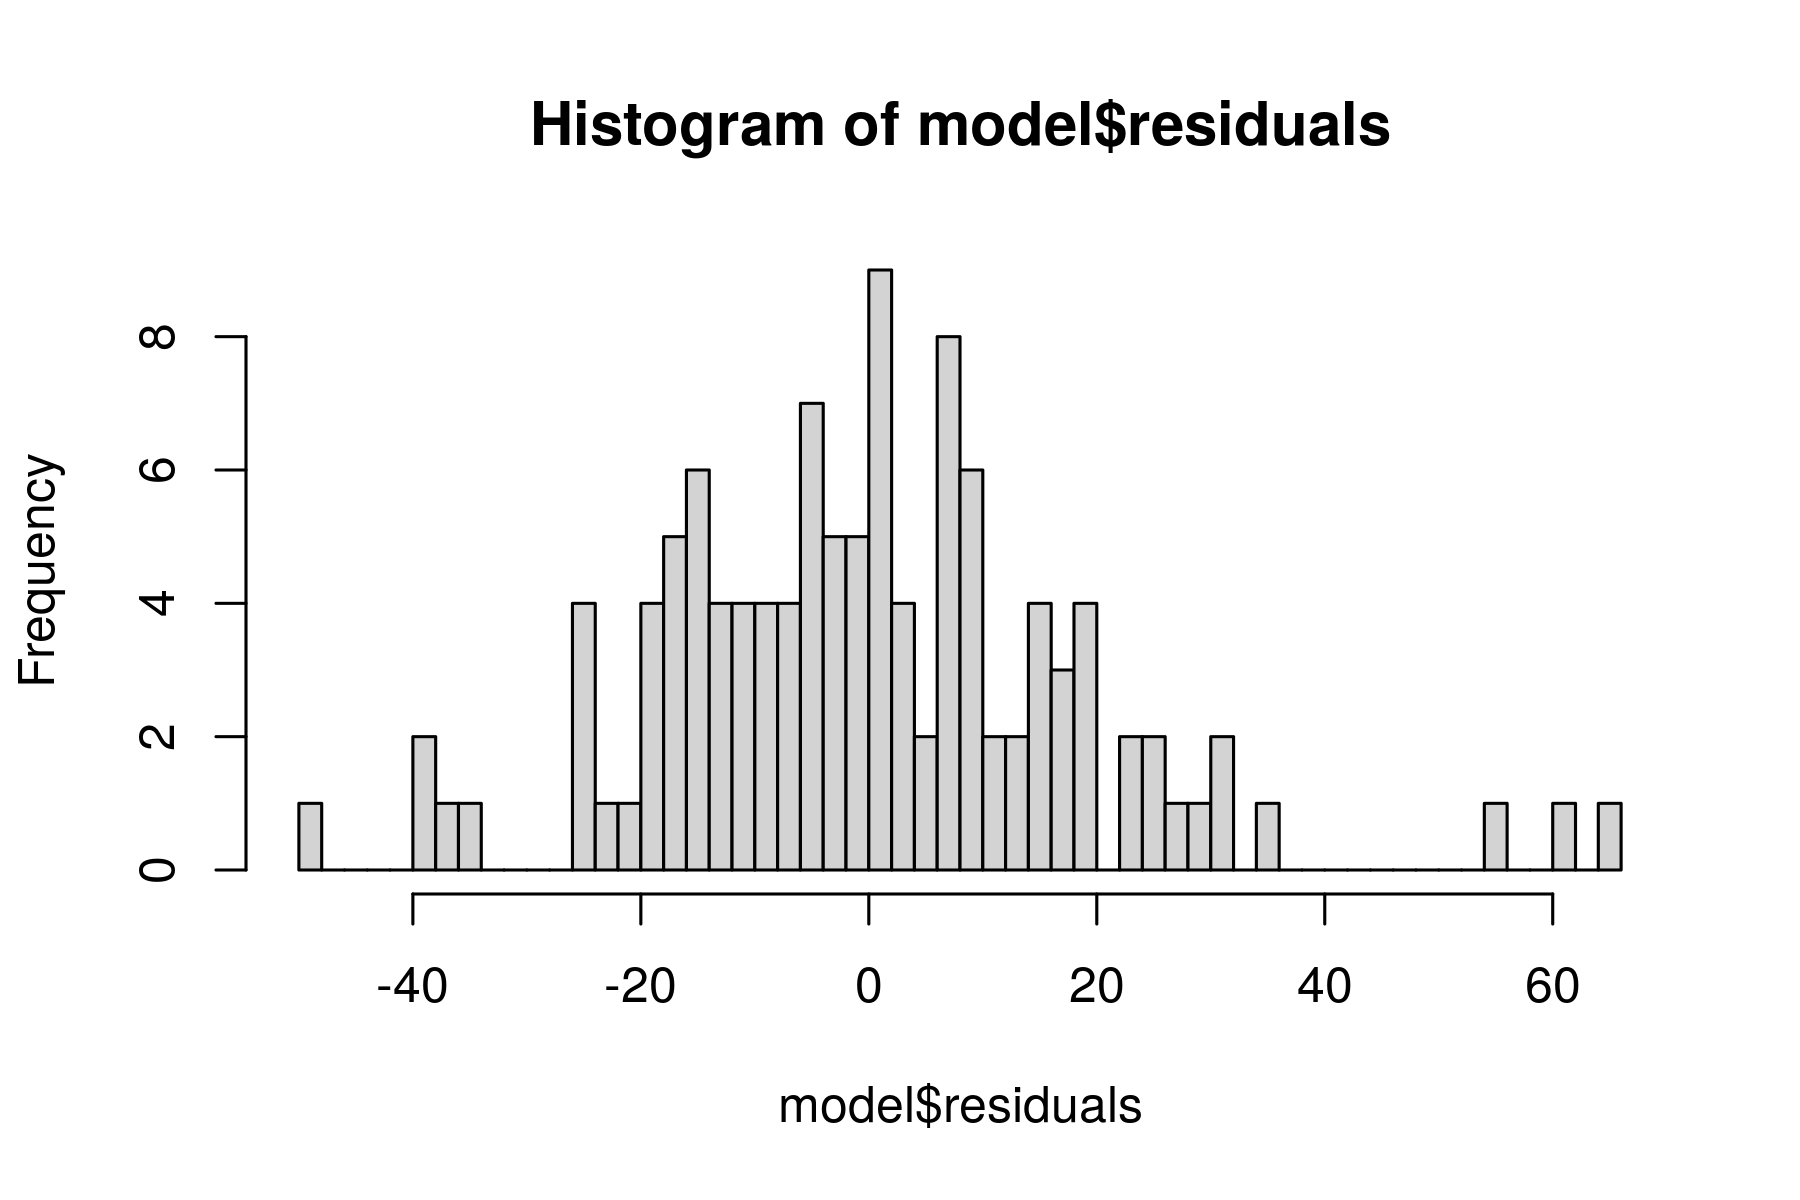

In [150]:
#representar el histograma de residuos
hist(model$residuals  ,50)

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates), con 1 baño, con un precio de 80€/noche y 3 habitaciones en el barrio de Sol, con 3 camas y un review de 80.
¿Cuantos metros cuadrados tendría? Si tu modelo necesita algúna variable adicional puedes inventartela dentro del rango de valores del dataset.
¿Como varía sus metros cuadrados con cada habitación adicional?

In [140]:
piso <- data.frame(Accommodates=6,
                    Bathrooms=1,
                    Price = 80,
                    Bedrooms=3,
                    Extra.People=5,
                    Guests.Included=2,
                    Neighb_id=as.factor(2),
                    Beds=3,
                    Review.Scores.Rating=80)

In [145]:
paste(round(predict(model, piso),digits = 2),"mt^2 tendría la habitacion")

[1] "86.08 mt^2 tendría la habitacion"

In [146]:
paste(round(model$coefficients['Bedrooms'],digits = 2),"mt^2 aumentaria por habitación adicional")

[1] "18.84 mt^2 aumentaria por habitación adicional"

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [152]:

df_madrid$Square.Meters[which(is.na(df_madrid$Square.Meters))]<- predict(model,df_madrid[which(is.na(df_madrid$Square.Meters)),])




Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

In [153]:
df_madrid <- na.omit(df_madrid) #quito NA
#estandarizo
pr_madrid <- prcomp(df_madrid[,c("Accommodates", "Bathrooms",
                                "Bedrooms", "Beds", "Price",
                                "Guests.Included", "Extra.People",
                                "Review.Scores.Rating", "Latitude",
                                "Longitude", "Square.Meters")],center = TRUE, scale. = TRUE)


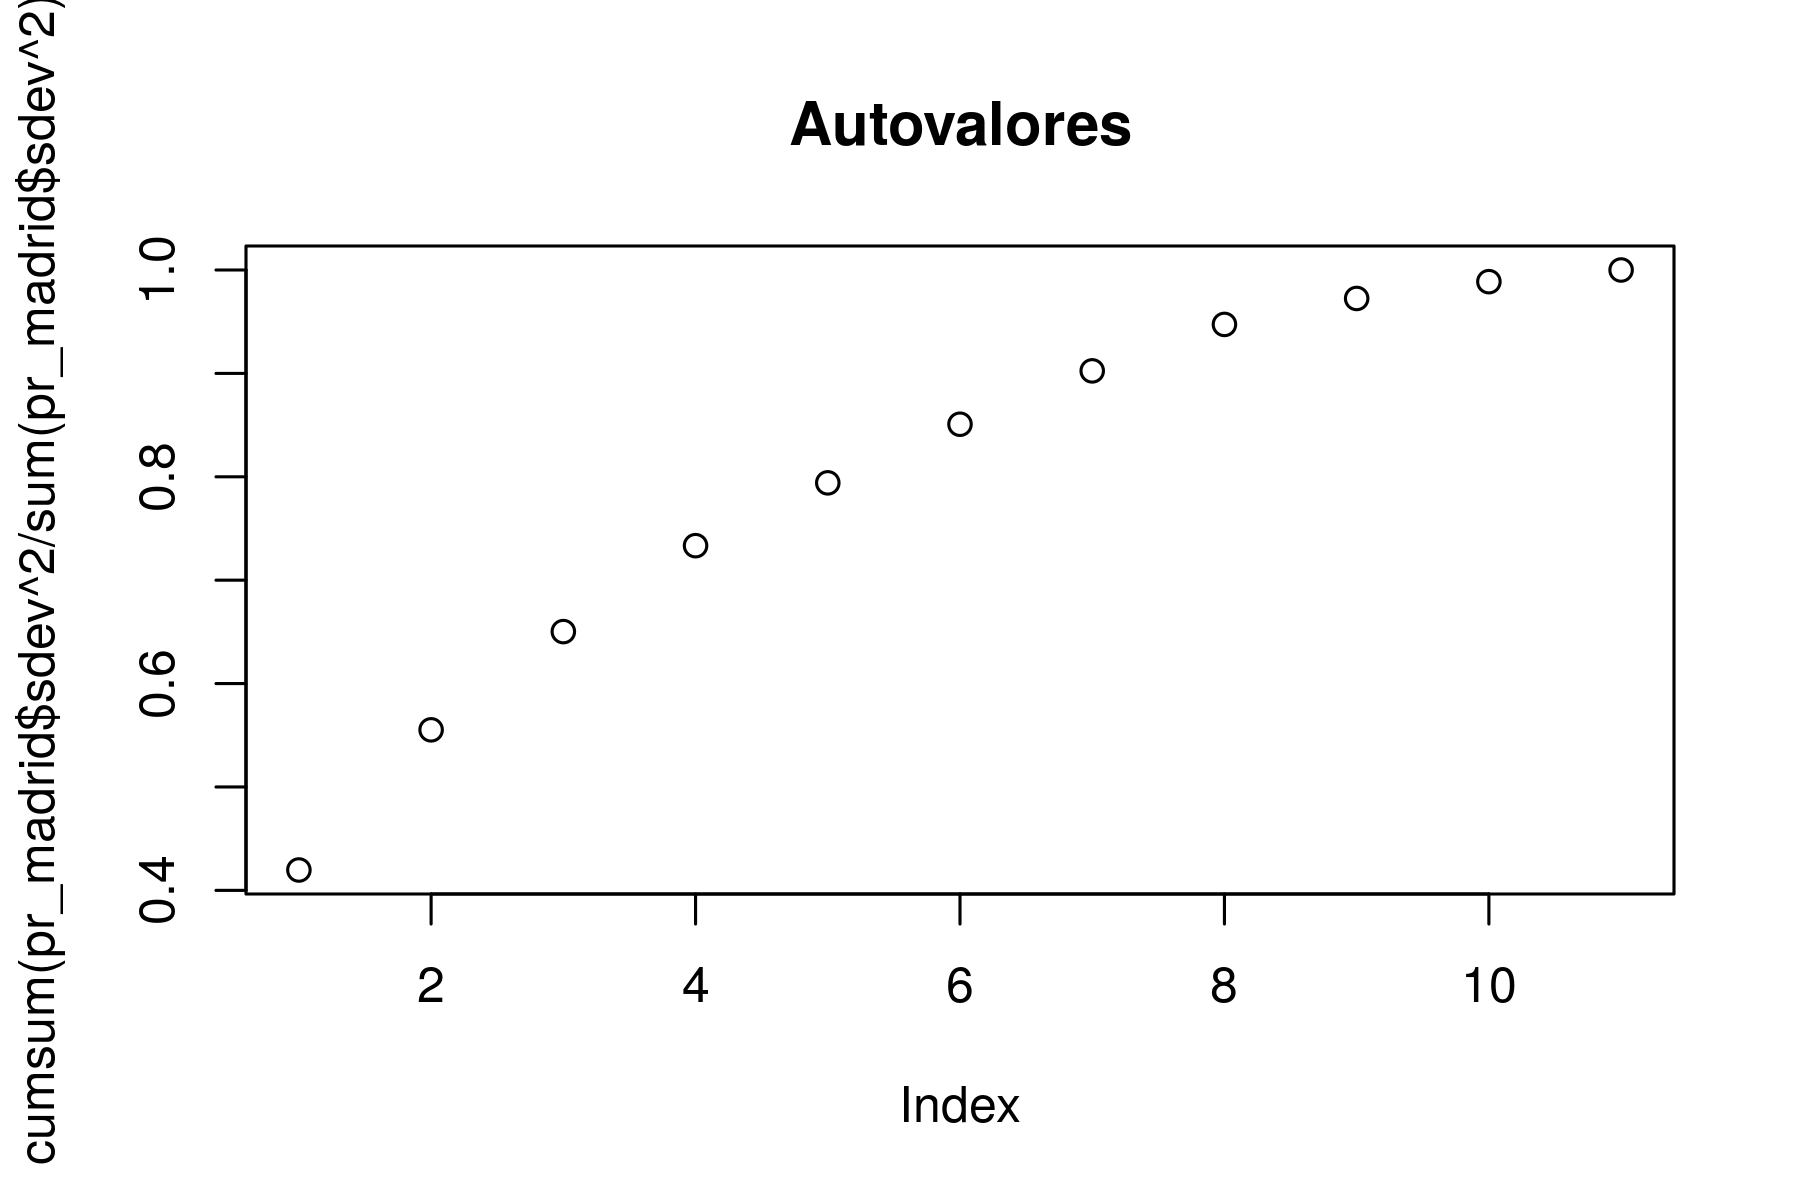

In [154]:
plot(cumsum(pr_madrid$sdev^2/sum(pr_madrid$sdev^2)),main="Autovalores")

In [156]:
head(df_madrid,1)

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,Neighb_id
,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
7,Acacias,4,1,1,3,68,807,2,10,90,40.39691,-3.705202,74.97272,2


In [157]:
n_pca <- 5
apc <- pr_madrid$x[,1:n_pca]
piso <- data.frame('Accommodates'=4,
                    'Bathrooms'=1,
                    'Bedrooms'=1,
                    'Beds'=1,
                    'Price'=69,
                    'Guests.Included'=2,
                    'Extra.People'=2,
                    'Review.Scores.Rating'=90,
                    'Latitude'=40.41697,
                    'Neighb_id'=as.factor(1),
                    'Longitude'=-3.709439,
                    'Square.Meters'=74)

In [162]:

piso.pca <- predict(model,piso)
piso.pca <- matrix(piso.pca[1:n_pca],nrow=1)
distancia <-rowSums((piso.pca[rep(1, times = nrow(apc)), ]-apc)^2)

paste("piso modelo")
piso
paste("5 similares")
df_madrid[c(order(distancia)[1:5]),]

[1] "piso modelo"

Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Neighb_id,Longitude,Square.Meters
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
4,1,1,1,69,2,2,90,40.41697,1,-3.709439,74


[1] "5 similares"

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,Neighb_id
,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
7,Acacias,4,1,1,3,68,807,2,10,90,40.39691,-3.705202,74.97272,2
15,Acacias,4,1,1,2,60,538,2,15,98,40.40513,-3.707726,49.98181,2
24,Acacias,4,1,2,4,70,0,4,15,91,40.40226,-3.703189,55.16963,2
32,Acacias,4,1,1,2,60,753,2,12,85,40.40073,-3.706203,69.95596,2
45,Adelfas,4,2,2,2,76,80,4,15,75,40.40606,-3.668898,79.38439,2


Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?